In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

In [2]:
current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: /Users/blaubach/chimes_CGD-myLLFork/dissimilarity_clustering


In [3]:
# Get the current working directory
cwd = os.getcwd()

# Define file paths with cwd appended
file_path_2b = os.path.join(cwd, "dft_pds/2b_all_pd")
file_path_3b = os.path.join(cwd, "dft_pds/3b_all_pd")
file_path_4b = os.path.join(cwd, "dft_pds/4b_all_pd")
file_path_labels = os.path.join(cwd, "dft_pds/labels_pd")
file_path_natoms = os.path.join(cwd, "test_notebooks/energies_per_atom.txt")

# Open pickle files with the updated file paths
with open(file_path_2b, 'rb') as pickle_file:
    pd_2b = pickle.load(pickle_file)

with open(file_path_3b, 'rb') as pickle_file:
    pd_3b = pickle.load(pickle_file)

with open(file_path_4b, 'rb') as pickle_file:
    pd_4b = pickle.load(pickle_file)

with open(file_path_labels, 'rb') as pickle_file:
    labels = pickle.load(pickle_file)

natom_list = []

# Open the text file for reading
with open(file_path_natoms, 'r') as file:

    # Read the contents of the file
    lines = file.readlines()[1:]

    # Iterate through each line
    for line in lines:

        # Split the line into words
        words = line.split()
        natoms = line.split("|")[1].strip()

        # Extract the last word, assuming it's a number
        last_number = float(words[-1])
        if words[0][-1] == 'z':
            print(words[0])
            continue
        natom_list.append(natoms)

natom_list = np.array(natom_list[:-10])

# Combine the arrays along the second axis (axis=1)
all_array = np.concatenate((pd_2b, pd_3b, pd_4b), axis=2)
all_array = all_array.reshape(-1, all_array.shape[2])
print(np.shape(all_array))
df_fingerprints = pd.DataFrame(all_array)

# Define the column labels for each set of columns
column_labels_2b = [f'2B_{i}' for i in range(60)]
column_labels_3b = [f'3B_{i}' for i in range(60)]
column_labels_4b = [f'4B_{i}' for i in range(60)]

# Assign the column labels to the DataFrame
column_labels = column_labels_2b + column_labels_3b + column_labels_4b
df_fingerprints.columns = column_labels

# Add a new column "labels" to the DataFrame and assign the new vector to it
df_fingerprints['labels'] = labels

# Calculate the row-wise mean using `mean(axis=1)`
row_avg = df_fingerprints.mean(axis=1)

# Append the calculated row-wise mean as a new column named "Pavg"
df_fingerprints['Pavg'] = row_avg

# Calculate the row-wise standard deviation using `std(axis=1)`
row_std = df_fingerprints.std(axis=1)

# Append the calculated row-wise standard deviation as a new column named "Pstd"
df_fingerprints['Pstd'] = row_std

# Append Natoms to Dataframe
df_fingerprints['Natoms'] = natom_list


training_data_#0000.xyz
training_data_#0050.xyz
training_data_#0055.xyz
training_data_#0060.xyz
training_data_#0075.xyz
training_data_#0080.xyz
training_data_#0110.xyz
(300, 180)


In [4]:
# Initialize the minimum occurrence count required
def compute_pij(phi1, phi2):

    # Compute statistics for training set
    phi1_fingerprint = phi1.iloc[:-4]
    avg_phi1 = phi1.iloc[-3]
    std_phi1 = phi1.iloc[-2]
    natoms_phi1 = float(phi1.iloc[-1])

    # Compute statistics for phi2
    phi2_fingerprint = phi2.iloc[:-4]
    avg_phi2 = phi2.iloc[-3]
    std_phi2 = phi2.iloc[-2]
    natoms_phi2 = float(phi2.iloc[-1])

    # Standardize Natoms
    natoms = np.sqrt(natoms_phi1*natoms_phi2)

    # Compute pij
    numerator = np.sum((phi1_fingerprint - avg_phi1)*(phi2_fingerprint - avg_phi2))
    denominator = natoms*std_phi1*std_phi2
    pij = numerator/denominator

    return pij

n = int(len(df_fingerprints))
pij_matrix = np.zeros((n,n))

# Iterate over each pair of rows
for i in range(n):
    for j in range(n):
        # Compute the scalar using compute_pij function
        pij = compute_pij(df_fingerprints.iloc[i], df_fingerprints.iloc[j])
        # Assign the scalar to the corresponding index in zeros_array
        pij_matrix[i, j] = pij

print(pij_matrix)

[[0.83610179 0.81729941 0.81652172 ... 0.01457645 0.01439321 0.01449416]
 [0.81729941 0.83588982 0.8350873  ... 0.01536529 0.01517977 0.01528734]
 [0.81652172 0.8350873  0.83587366 ... 0.01540713 0.01522133 0.01532995]
 ...
 [0.01457645 0.01536529 0.01540713 ... 0.00547451 0.00547592 0.00547502]
 [0.01439321 0.01517977 0.01522133 ... 0.00547592 0.00547899 0.00547697]
 [0.01449416 0.01528734 0.01532995 ... 0.00547502 0.00547697 0.00547584]]


<Axes: >

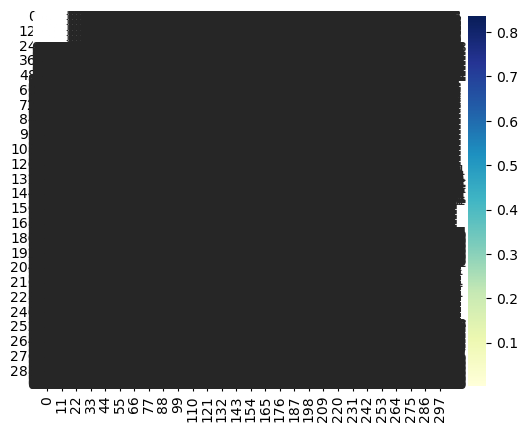

In [5]:
import seaborn as sns

# Calculate the sum of each column
column_sums = np.sum(pij_matrix, axis=0)

# Normalize each column
normalized_matrix = pij_matrix / column_sums

# Create a heatmap using Seaborn
sns.heatmap(pij_matrix, annot=True, cmap="YlGnBu") 

In [7]:
# Step 1: Calculate the diagonal elements
diagonal_elements = np.diag(pij_matrix)

# Step 2: Calculate the magnitude of each diagonal element
magnitude_diagonal_elements = np.sqrt(np.sum(diagonal_elements ** 2))

# Step 3: Divide each column by the magnitude of the corresponding diagonal element
normalized_matrix = pij_matrix / magnitude_diagonal_elements

print(normalized_matrix)

[[0.19933891 0.19485615 0.19467074 ... 0.00347524 0.00343155 0.00345562]
 [0.19485615 0.19928837 0.19909704 ... 0.00366331 0.00361908 0.00364473]
 [0.19467074 0.19909704 0.19928452 ... 0.00367329 0.00362899 0.00365488]
 ...
 [0.00347524 0.00366331 0.00367329 ... 0.0013052  0.00130554 0.00130532]
 [0.00343155 0.00361908 0.00362899 ... 0.00130554 0.00130627 0.00130579]
 [0.00345562 0.00364473 0.00365488 ... 0.00130532 0.00130579 0.00130552]]


In [8]:
diagonal_elements

array([0.83610179, 0.83588982, 0.83587366, 0.83488505, 0.83494041,
       0.83550023, 0.83565424, 0.83498312, 0.83502244, 0.83566514,
       0.83526859, 0.83497636, 0.8356722 , 0.83527499, 0.83539328,
       0.83534964, 0.83510284, 0.83546845, 0.83501307, 0.83546072,
       0.83517956, 0.83515396, 0.83558449, 0.83500447, 0.83556381,
       0.05537768, 0.03208823, 0.033227  , 0.03299183, 0.03303652,
       0.03326779, 0.03317609, 0.03298799, 0.03322978, 0.03317757,
       0.03312926, 0.03322807, 0.03331056, 0.03279672, 0.03302363,
       0.03314518, 0.03299913, 0.03303493, 0.0328299 , 0.03289462,
       0.03317242, 0.03319623, 0.03289966, 0.03330865, 0.03300633,
       0.07507949, 0.051894  , 0.0503173 , 0.04507444, 0.04615708,
       0.05514801, 0.046125  , 0.04581237, 0.03932879, 0.04153015,
       0.04525375, 0.04366257, 0.04547099, 0.04469214, 0.04469078,
       0.0436081 , 0.0442222 , 0.04280692, 0.04643874, 0.04661691,
       0.04507311, 0.04185104, 0.04269398, 0.04168868, 0.03945

[[1.         0.97775974 0.97684825 ... 2.66260218 2.62698068 2.64693055]
 [0.97751185 1.         0.99905923 ... 2.8066953  2.77053985 2.79178256]
 [0.97658171 0.99903993 1.         ... 2.81433828 2.77812537 2.7995635 ]
 ...
 [0.01743382 0.01838195 0.01843237 ... 1.         0.99943947 0.999851  ]
 [0.01721466 0.01816001 0.01821009 ... 1.00025758 1.         1.00020646]
 [0.0173354  0.01828871 0.01834003 ... 1.00009263 0.99962992 1.        ]]


<Axes: >

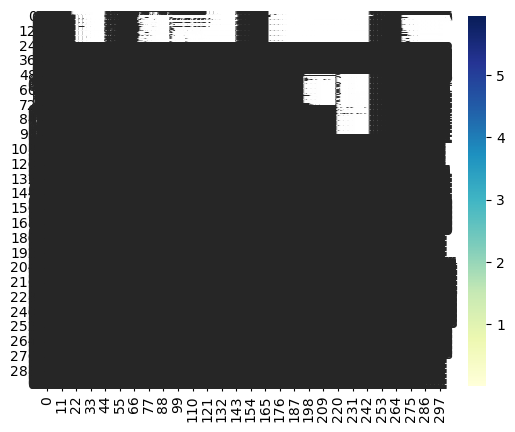

In [13]:
# Create a new matrix to store the results
new_matrix = np.empty_like(pij_matrix, dtype=float)

for idx, column in enumerate(pij_matrix.T):
    new_matrix[:, idx] = column / diagonal_elements[idx]

print(new_matrix)

sns.heatmap(new_matrix, cmap="YlGnBu") 

In [15]:
np.max(new_matrix)
np.min(new_matrix)

0.016657299800913017